What are the mechanisms that cause mixing the the sill region? Other literature suggests
* Hydraulic jumps (Griffins and Leblond and their Froude number discussion)
* Internal tides (one of Rich's papers saw internal tides in Haro Strait. I don't remember if he said it causes mixing but there is potential).
* Shear currents
* Separation induced mixing (a Rich and Farmer paper)
* Eddies in Boundary Pass (one of Ann Gargett's papers)

Can we find evidence of these features in the model?

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os

from nowcast import figures
from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
def results_dataset(time, date, grid, mode):
    fname = 'SalishSea_{}_{}_{}_{}.nc'.format(time, date.strftime('%Y%m%d'),
                                              date.strftime('%Y%m%d'), grid)
    results= '/results/SalishSea/{}/'.format(mode)
    subdir=date.strftime('%d%b%y').lower()
    path = os.path.join(results,subdir,fname)
    dataset = nc.Dataset(path)
    
    return dataset

In [3]:
d = datetime.datetime(2015,7,27)

grid_t = results_dataset('1h',d,'grid_T','nowcast')
grid_u = results_dataset('1h',d,'grid_U','nowcast')
grid_v = results_dataset('1h',d,'grid_V','nowcast')
lons=grid_t.variables['nav_lon'][:]
lats=grid_t.variables['nav_lat'][:]

mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
tmask = mesh.variables['tmask'][:]
tmask = 1-tmask

umask = mesh.variables['umask'][:]
umask = 1-umask

vmask = mesh.variables['vmask'][:]
vmask = 1-vmask

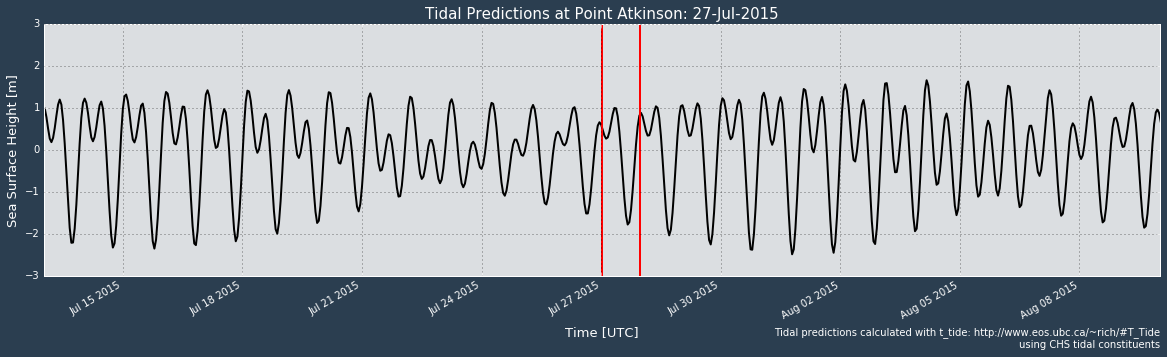

In [4]:
tidal_predictions='/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/tidal_predictions/'
fig=figures.PA_tidal_predictions(grid_t,tidal_predictions,PST=0)

In [5]:
sal = grid_t.variables['vosaline'][:]
tmask = tmask +np.zeros(sal.shape)
lines = np.loadtxt('/data/nsoontie/MEOPAR/tools/bathymetry/thalweg_working.txt',delimiter=' ', dtype=int)
depth = grid_t.variables['deptht'][:]
sal = np.ma.masked_array(sal,mask=tmask)
times = grid_t.variables['time_counter']
dates= nc.num2date(times[:],times.units)

In [6]:
u = grid_u.variables['vozocrtx'][:]
umask = umask +np.zeros(u.shape)
depthu = grid_u.variables['depthu'][:]
u = np.ma.masked_array(u,mask=umask)

v = grid_v.variables['vomecrty'][:]
vmask = vmask +np.zeros(v.shape)
depthv = grid_v.variables['depthv'][:]
v = np.ma.masked_array(v,mask=vmask)


## Hydraulic Jump/ Large amplitude internal tide
* I don't think the hydrostatic model can represent the physics of the hydraulic jump, but can it pick up on the conditions that lead to one and at least capture some of the mixing? For example, strong shear, change in criticality of the flow...

In [7]:
def plot_thalweg(ax, t, sal, dates, lines, depth,smin=20,smax=34,ylim=[430,0],xlim=[0,1000]):
    
    salP=sal[t,:,lines[:,0],lines[:,1]]
    mesh=ax.pcolormesh(np.arange(salP.shape[0]),depth,salP.T,vmin=smin,vmax=smax)
    
    CS = ax.contour(np.arange(salP.shape[0]),depth,salP.T,[29,30,31],colors='k')
    plt.clabel(CS)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('Salinity [psu]')
    cbar.add_lines(CS)
    
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Depth [m]')
    ax.set_title(dates[t].strftime('%d-%b-%Y %H:%M'))

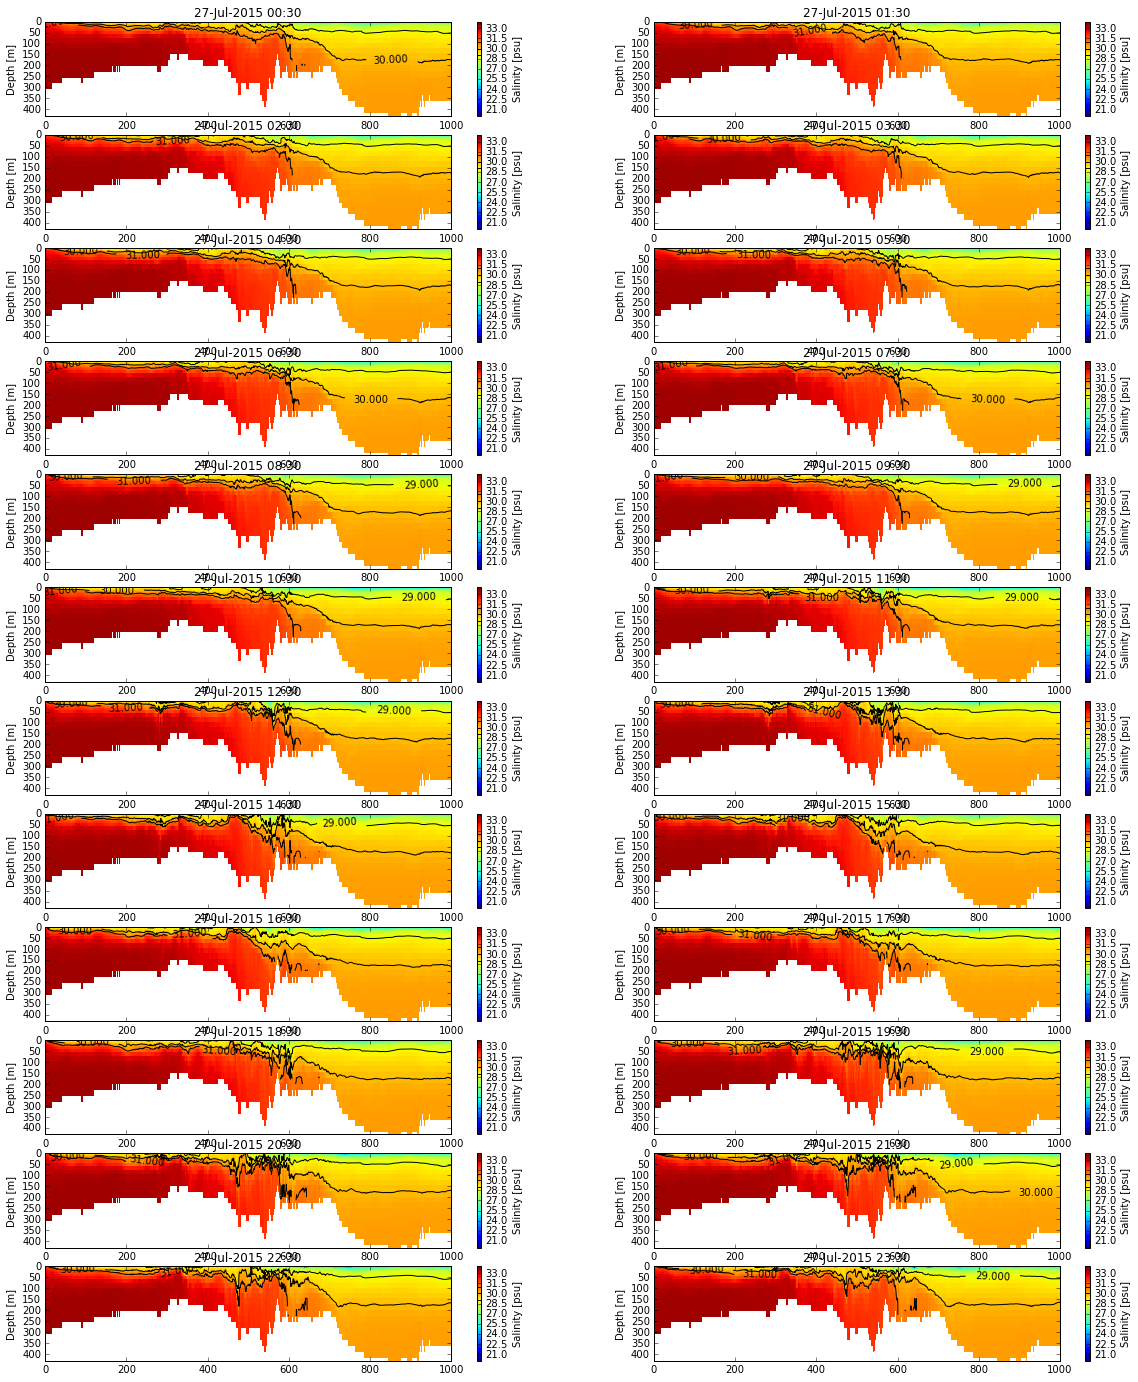

In [8]:
fig,axs = plt.subplots(12,2,figsize=(20,24))
for t, ax in zip(np.arange(0,sal.shape[0]),axs.flat):
    plot_thalweg(ax,t,sal,dates,lines,depth)

* In a movie it is clearer, but I'm convinced there is a large amplitude wave-like motion between about x=400 and x=600.
* Should this be described as a wave or just the oscillating front of a gravity current? Or a seiche?
* Keep in mind that x=400 to 600 spans a large distance and the direction of the currents changes a lot. 
* One of Rich's paper sees a wave like this and it is in the Haro Strait region. He suggests that it should propagate into the Strait of Georgia. 
* Could this wave explain the timing of the renewals?

## Shear
* Are there strong shear currents that lead to mixing?

In [9]:
def hovmoller_depth(ax,var,varname,depth,times,thalweg_points, index, title,ylim=[250,0],smin=-1,smax=1):
    
    varP=var[:,:,thalweg_points[:,0],thalweg_points[:,1]]
    varP =  varP[:,:, index]
    mesh=ax.pcolormesh(times,depth,varP.T,vmin=smin, vmax=smax)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label(varname)
    ax.set_ylim(ylim)
    ax.set_ylabel('depth [m]')
    ax.set_title('{} at thalweg index {}'.format(title, index))

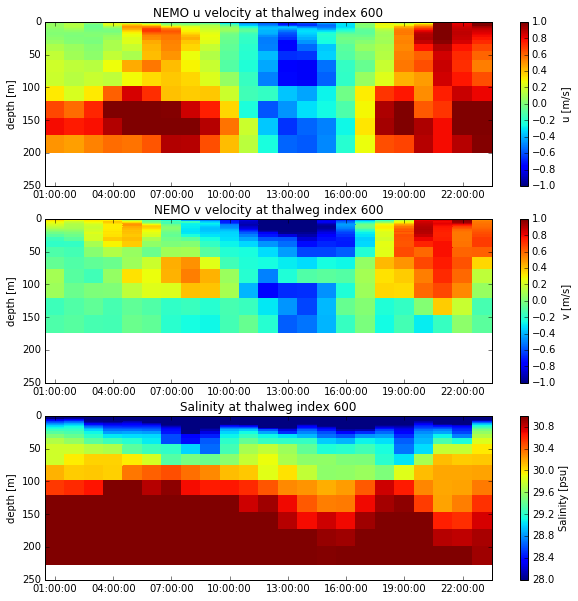

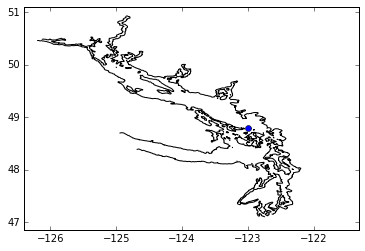

In [10]:
fig,axs=plt.subplots(3,1,figsize=(10,10))
smin,smax=-1,1
ind=600
ax=axs[0]
hovmoller_depth(ax,u,'u [m/s]',depthu, dates, lines, ind, 'NEMO u velocity',smin=smin,smax=smax)
ax=axs[1]
hovmoller_depth(ax,v,'v [m/s]',depthv, dates, lines, ind, 'NEMO v velocity',smin=smin,smax=smax)
ax=axs[2]
smin,smax=28,31
hovmoller_depth(ax,sal,'Salinity [psu]',depth, dates, lines, ind, 'Salinity',smin=smin,smax=smax)
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.plot(lons[lines[ind,0], lines[ind,1]], lats[lines[ind,0],lines[ind,1]],'o')

* Boundary pass - mixed water column is associated with strong flood.
* How do you separate adection from mixing?

Idea: 
* Average boundary pass velocities and stratification profiles during different stages of the tide (flood, ebb etc).
* Is there a difference between spring/neap
* Can this be applied to other areas?

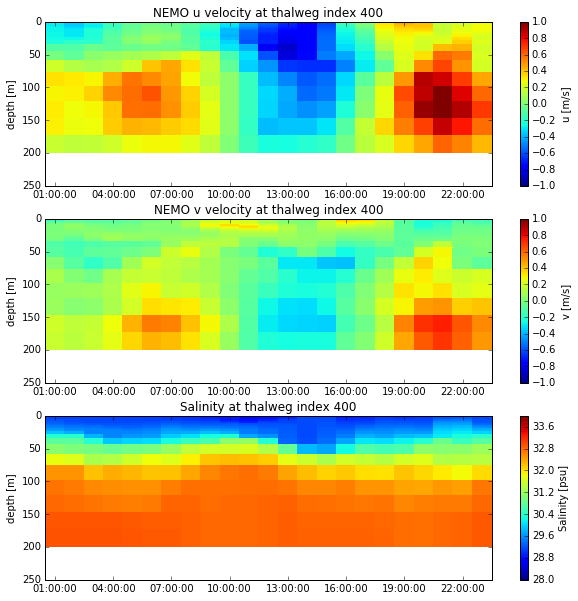

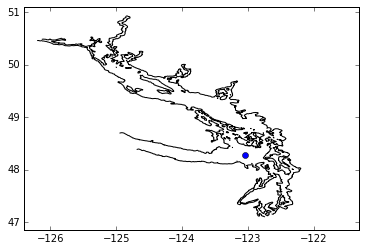

In [11]:
fig,axs=plt.subplots(3,1,figsize=(10,10))
smin,smax=-1,1
ind=400
ax=axs[0]
hovmoller_depth(ax,u,'u [m/s]',depthu, dates, lines, ind, 'NEMO u velocity',smin=smin,smax=smax)
ax=axs[1]
hovmoller_depth(ax,v,'v [m/s]',depthv, dates, lines, ind, 'NEMO v velocity',smin=smin,smax=smax)
ax=axs[2]
smin,smax=28,34
hovmoller_depth(ax,sal,'Salinity [psu]',depth, dates, lines, ind, 'Salinity',smin=smin,smax=smax)
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.plot(lons[lines[ind,0], lines[ind,1]], lats[lines[ind,0],lines[ind,1]],'o')

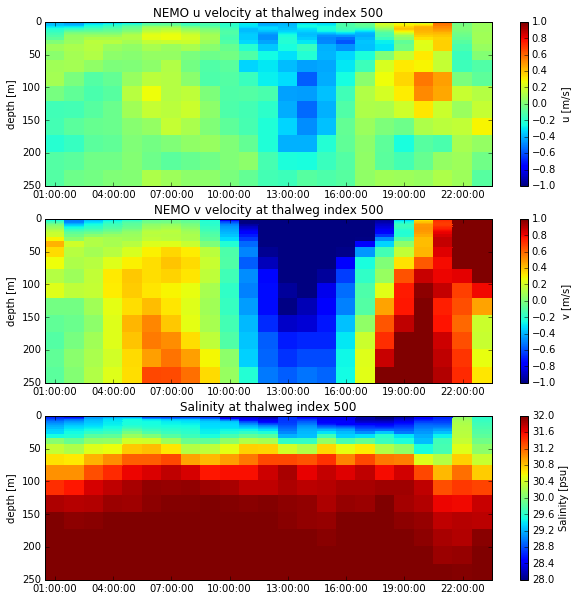

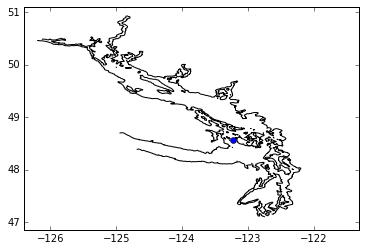

In [12]:
fig,axs=plt.subplots(3,1,figsize=(10,10))
smin,smax=-1,1
ind=500
ax=axs[0]
hovmoller_depth(ax,u,'u [m/s]',depthu, dates, lines, ind, 'NEMO u velocity',smin=smin,smax=smax)
ax=axs[1]
hovmoller_depth(ax,v,'v [m/s]',depthv, dates, lines, ind, 'NEMO v velocity',smin=smin,smax=smax)
ax=axs[2]
smin,smax=28,32
hovmoller_depth(ax,sal,'Salinity [psu]',depth, dates, lines, ind, 'Salinity',smin=smin,smax=smax)
fig,ax=plt.subplots(1,1)
viz_tools.plot_coastline(ax,grid_B,coords='map')
ax.plot(lons[lines[ind,0], lines[ind,1]], lats[lines[ind,0],lines[ind,1]],'o')